In [1]:
%load_ext autoreload
%autoreload 2
import wavesight as ws
import numpy as np

Numba not available, defining a dummy jit decorator.


In [2]:
def device_layout(device_design):
    '''
    This function creates a figure representing the device layout.
    
    Parameters
    ----------
    device_design : dict with at least the following keys:
        coreRadius : float
            the radius of the core in μm
        mlRadius : float
            the radius of the metalens in μm
        Δ : float
            the distance between the end face of the
            fiber and the start of the metalens in μm
        mlPitch : float
            the pitch of the metalens in μm
        emDepth : float
            the  depth of the emitter in the
            crystal  host  in μm, measured from the base of the
            metalens pillars
        emΔxy : float
            the lateral uncertainty (in μm) in
            the position of the emitter
        emΔz : float
            the uncertainty in the axial position
            of the emitter in μm
        mlHeight : float
            the height of the metalens in μm
        λFree  : float
            the  free-space  wavelength of the
            emitter in μm
        nCore : float
            the refractive index of the core
        nHost : float
            the refractive index of the host
        nClad : float
            the refractive index of the cladding
        NA : float
            the numerical aperture of the fiber

    
    Returns
    -------
    fig, ax: the figure and axis objects

    '''
    def CenteredRectangle(xy, width, height, **opts):
        x, y = xy
        return Rectangle((x - width/2, y - height/2), width, height, **opts)
    def BottomRectangle(xy, width, height, **opts):
        x, y = xy
        return Rectangle((x - width/2, y), width, height, **opts)
    coreRadius  = device_design['coreRadius']
    mlRadius    = device_design['mlRadius']
    Δ           = device_design['Δ']
    mlPitch     = device_design['mlPitch']
    emDepth     = device_design['emDepth']
    emΔxy       = device_design['emΔxy']
    emΔz        = device_design['emΔz']
    mlHeight    = device_design['mlHeight']
    λFree       = device_design['λFree']
    nCore       = device_design['nCore']
    nHost       = device_design['nHost']
    wholeWidth  = 1.2*2*max(coreRadius, mlRadius)
    textframe   = wholeWidth * 0.05
    fiberTip    = emDepth* 0.75
    NA          = device_design['NA']
    if 'nCladding' not in device_design:
        nCladding = np.sqrt(nCore**2 - NA**2)
    else:
        nCladding = device_design['nCladding']
    designSpec  = [f'λFree = {λFree*1000} nm',
                f'Δ = {Δ} μm',
                f'coreRad = {coreRadius} μm',
                f'mlHeight = {mlHeight} μm',
                f'emDepth = {emDepth} μm',
                f'Δxy = {emΔxy} μm',
                f'nCore = {nCore}',
                f'nHost = {nHost}',
                'nClad = %.2f' % nCladding,
                'fiberNA = %.2f' % NA,
                f'Δz = {emΔz} μm']
    designSpec = list(sorted(designSpec, key=lambda x: -len(x)))
    designSpec = '\n'.join(designSpec)
    wholeHeight = (fiberTip + Δ + mlHeight + emDepth + 4 * emΔz)
    top_left_corner = (-wholeWidth/2 + textframe, wholeHeight-fiberTip - textframe)
    finalFieldWidth  =  2*emΔxy*1
    finalFieldHeight =  2*emΔz*1
    fig, ax = plt.subplots()
    clad = BottomRectangle((0, 0-fiberTip), wholeWidth, fiberTip, color='c', alpha=0.5)
    ax.add_patch(clad)
    core = BottomRectangle((0, 0-fiberTip), coreRadius*2, fiberTip, color='r', alpha=0.5)
    ax.add_patch(core)
    ml = BottomRectangle((0, fiberTip + Δ - fiberTip), 2*mlRadius, mlHeight, color='g', alpha=0.5)
    ax.add_patch(ml)
    host = BottomRectangle((0, fiberTip + Δ + mlHeight - fiberTip), wholeWidth, wholeHeight, color='g', alpha=0.3)
    ax.add_patch(host)
    fieldBox = CenteredRectangle((0, fiberTip + Δ + mlHeight + emDepth - fiberTip), finalFieldWidth, finalFieldHeight, color='w', alpha=0.5)
    ax.add_patch(fieldBox)
    ax.set_xlim(-wholeWidth/2, wholeWidth/2)
    ax.set_ylim(-fiberTip, wholeHeight - fiberTip)
    ax.plot(([0,0],[0- fiberTip, wholeHeight- fiberTip]), 'w:', lw=1, alpha=0.2)
    ax.text(*top_left_corner, designSpec, fontsize=9, ha='left', va = 'top', fontdict={'family': 'monospace'})
    ax.set_xlabel('x/μm')
    ax.set_ylabel('z/μm')
    ax.set_aspect('equal')
    plt.close()
    return fig, ax

In [3]:
device_design = {}
device_design['coreRadius'] = 2.0
device_design['NAf']        = 0.1
device_design['emDepth']    = 20
device_design['mlRadius']   = 10.
device_design['mlPitch']    = 250.0
device_design['nCore']      = 1.5
device_design['nUpper']     = 1.0
device_design['nHost']      = 2.41  
device_design['λFree']      = 0.532
device_design['mlHeight']   = 1.0
device_design['emΔxy']      = 3.0
device_design['emΔz']       = 10.0
def dependent_device_params(device_design):
    coreRadius = device_design['coreRadius']
    NAf    = device_design['NAf']
    emDepth    = device_design['emDepth']
    mlRadius = device_design['mlRadius']
    nCore      = device_design['nCore']
    nUpper     = device_design['nUpper']
    nHost   = device_design['nHost']
    # calculate β
    β = np.arcsin(NAf)
    device_design['β'] = β
    # (*calculate δ*)
    δ = coreRadius / np.tan(β)
    device_design['δ'] = δ
    # calculate D the separation between fiber and metasurface
    Δ = (mlRadius - coreRadius) / np.tan(β)
    device_design['Δ'] = Δ
    # calculate the paraxial focal length
    finverse = nHost/emDepth + nUpper/Δ
    f = 1/finverse
    device_design['f'] = f
    return device_design

In [4]:
dependent_device_params(device_design)

{'coreRadius': 2.0,
 'NAf': 0.1,
 'emDepth': 20,
 'mlRadius': 10.0,
 'mlPitch': 250.0,
 'nCore': 1.5,
 'nUpper': 1.0,
 'nHost': 2.41,
 'λFree': 0.532,
 'mlHeight': 1.0,
 'emΔxy': 3.0,
 'emΔz': 10.0,
 'β': 0.1001674211615598,
 'δ': 19.8997487421324,
 'Δ': 79.5989949685296,
 'f': 7.515238685702307}

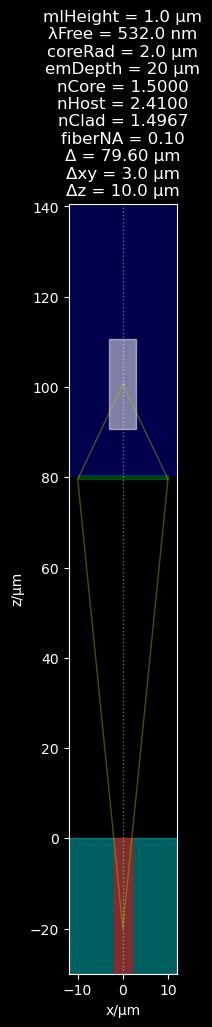

In [5]:
fig, ax = ws.device_layout(device_design, False)
fig

In [15]:
def better_device_layout(device_design):
    '''
    This function creates a figure representing the device layout.
    
    Parameters
    ----------
    device_design : dict with at least the following keys:
        coreRadius : float
            the radius of the core in μm
        mlRadius : float
            the radius of the metalens in μm
        Δ : float
            the distance between the end face of the
            fiber and the start of the metalens in μm
        mlPitch : float
            the pitch of the metalens in μm
        emDepth : float
            the  depth of the emitter in the
            crystal  host  in μm, measured from the base of the
            metalens pillars
        emΔxy : float
            the lateral uncertainty (in μm) in
            the position of the emitter
        emΔz : float
            the uncertainty in the axial position
            of the emitter in μm
        mlHeight : float
            the height of the metalens in μm
        λFree  : float
            the  free-space  wavelength of the
            emitter in μm
        nCore : float
            the refractive index of the core
        nHost : float
            the refractive index of the host
        nClad : float
            the refractive index of the cladding
        NA : float
            the numerical aperture of the fiber

    
    Returns
    -------
    fig, ax: the figure and axis objects

    '''
    def CenteredRectangle(xy, width, height, **opts):
        x, y = xy
        return Rectangle((x - width/2, y - height/2), width, height, **opts)
    def BottomRectangle(xy, width, height, **opts):
        x, y = xy
        return Rectangle((x - width/2, y), width, height, **opts)
    coreRadius  = device_design['coreRadius']
    mlRadius    = device_design['mlRadius']
    Δ           = device_design['Δ']
    mlPitch     = device_design['mlPitch']
    emDepth     = device_design['emDepth']
    emΔxy       = device_design['emΔxy']
    emΔz        = device_design['emΔz']
    mlHeight    = device_design['mlHeight']
    λFree       = device_design['λFree']
    nCore       = device_design['nCore']
    nHost       = device_design['nHost']
    wholeWidth  = 1.2*2*max(coreRadius, mlRadius)
    textframe   = wholeWidth * 0.05
    fiberTip    = emDepth* 0.75
    NA          = device_design['NA']
    if 'nCladding' not in device_design:
        nCladding = np.sqrt(nCore**2 - NA**2)
    else:
        nCladding = device_design['nCladding']
    designSpec  = [f'λFree = {λFree*1000} nm',
                f'Δ = {Δ} μm',
                f'coreRad = {coreRadius} μm',
                f'mlHeight = {mlHeight} μm',
                f'emDepth = {emDepth} μm',
                f'Δxy = {emΔxy} μm',
                f'nCore = {nCore}',
                f'nHost = {nHost}',
                'nClad = %.2f' % nCladding,
                'fiberNA = %.2f' % NA,
                f'Δz = {emΔz} μm']
    designSpec = list(sorted(designSpec, key=lambda x: -len(x)))
    designSpec = '\n'.join(designSpec)
    wholeHeight = (fiberTip + Δ + mlHeight + emDepth + 4 * emΔz)
    top_left_corner = (-wholeWidth/2 + textframe, wholeHeight-fiberTip - textframe)
    finalFieldWidth  =  2*emΔxy*1
    finalFieldHeight =  2*emΔz*1
    fig, ax = plt.subplots()
    clad = BottomRectangle((0, 0-fiberTip), wholeWidth, fiberTip, color='c', alpha=0.5)
    ax.add_patch(clad)
    core = BottomRectangle((0, 0-fiberTip), coreRadius*2, fiberTip, color='r', alpha=0.5)
    ax.add_patch(core)
    ml = BottomRectangle((0, fiberTip + Δ - fiberTip), 2*mlRadius, mlHeight, color='g', alpha=0.5)
    ax.add_patch(ml)
    host = BottomRectangle((0, fiberTip + Δ + mlHeight - fiberTip), wholeWidth, wholeHeight, color='g', alpha=0.3)
    ax.add_patch(host)
    fieldBox = CenteredRectangle((0, fiberTip + Δ + mlHeight + emDepth - fiberTip), finalFieldWidth, finalFieldHeight, color='w', alpha=0.5)
    ax.add_patch(fieldBox)
    ax.set_xlim(-wholeWidth/2, wholeWidth/2)
    ax.set_ylim(-fiberTip, wholeHeight - fiberTip)
    ax.plot(([0,0],[0- fiberTip, wholeHeight- fiberTip]), 'w:', lw=1, alpha=0.2)
    ax.text(*top_left_corner, designSpec, fontsize=9, ha='left', va = 'top', fontdict={'family': 'monospace'})
    ax.set_xlabel('x/μm')
    ax.set_ylabel('z/μm')
    ax.set_aspect('equal')
    plt.close()
    return fig, ax